<a href="https://colab.research.google.com/github/lualua0909/DeepLearning-LDS8/blob/main/Week_5/Chapter_11_GANs_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Chapter 11: GANs - CIFAR**

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.layers import Convolution2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.datasets import cifar10

In [3]:
#K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
random_dim = 100

In [4]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# summarize the shape of the dataset
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


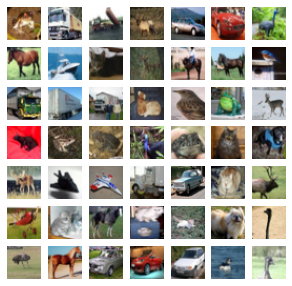

In [5]:
# plot images from the training dataset
plt.figure(figsize=(5,5))
for i in range(49):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(X_train[i])
plt.show()

In [6]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], 3072)

In [7]:
def load_cifar_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (50000, 32, 32, 3) to (50000, 3072) so we have
    # 32x32x3 = 3072 columns per row
    x_train = x_train.reshape(50000, 3072)
    return (x_train, y_train, x_test, y_test)

In [8]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [9]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(512, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(3072))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(6144))
    generator.add(LeakyReLU(0.2))    

    generator.add(Dense(3072, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [10]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(6144, input_dim=3072, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(3072))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [11]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [12]:
# Create a wall of generated cifar images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(5, 5)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 32, 32, 3)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r') 
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('cifar_gan_generated_image_epoch_%d.png' % epoch)

In [13]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_cifar_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], 
                                                    size=batch_size)]

            # Generate fake cifar images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

In [ ]:
train(300, 128)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 1 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 2 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.79it/s]


--------------- Epoch 3 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.78it/s]


--------------- Epoch 4 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.87it/s]


--------------- Epoch 5 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.89it/s]


--------------- Epoch 6 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.95it/s]


--------------- Epoch 7 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.09it/s]


--------------- Epoch 8 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.94it/s]


--------------- Epoch 9 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.03it/s]


--------------- Epoch 10 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.97it/s]


--------------- Epoch 11 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.98it/s]


--------------- Epoch 12 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.06it/s]


--------------- Epoch 13 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.99it/s]


--------------- Epoch 14 ---------------


100%|██████████| 390/390 [01:03<00:00,  6.11it/s]


--------------- Epoch 15 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.98it/s]


--------------- Epoch 16 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.04it/s]


--------------- Epoch 17 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.98it/s]


--------------- Epoch 18 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.98it/s]


--------------- Epoch 19 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.99it/s]


--------------- Epoch 20 ---------------


100%|██████████| 390/390 [01:05<00:00,  6.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 21 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.62it/s]


--------------- Epoch 22 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.80it/s]


--------------- Epoch 23 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.91it/s]


--------------- Epoch 24 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.95it/s]


--------------- Epoch 25 ---------------


100%|██████████| 390/390 [01:05<00:00,  6.00it/s]


--------------- Epoch 26 ---------------


100%|██████████| 390/390 [01:03<00:00,  6.12it/s]


--------------- Epoch 27 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.08it/s]


--------------- Epoch 28 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.02it/s]


--------------- Epoch 29 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.01it/s]


--------------- Epoch 30 ---------------


100%|██████████| 390/390 [01:03<00:00,  6.14it/s]


--------------- Epoch 31 ---------------


100%|██████████| 390/390 [01:02<00:00,  6.20it/s]


--------------- Epoch 32 ---------------


100%|██████████| 390/390 [01:03<00:00,  6.10it/s]


--------------- Epoch 33 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.04it/s]


--------------- Epoch 34 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.95it/s]


--------------- Epoch 35 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.91it/s]


--------------- Epoch 36 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.79it/s]


--------------- Epoch 37 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.99it/s]


--------------- Epoch 38 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.97it/s]


--------------- Epoch 39 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.83it/s]


--------------- Epoch 40 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 41 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.50it/s]


--------------- Epoch 42 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.55it/s]


--------------- Epoch 43 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.54it/s]


--------------- Epoch 44 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.44it/s]


--------------- Epoch 45 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.37it/s]


--------------- Epoch 46 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.64it/s]


--------------- Epoch 47 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.61it/s]


--------------- Epoch 48 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.64it/s]


--------------- Epoch 49 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.66it/s]


--------------- Epoch 50 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.69it/s]


--------------- Epoch 51 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.61it/s]


--------------- Epoch 52 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.71it/s]


--------------- Epoch 53 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.80it/s]


--------------- Epoch 54 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 55 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.69it/s]


--------------- Epoch 56 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.76it/s]


--------------- Epoch 57 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.73it/s]


--------------- Epoch 58 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.76it/s]


--------------- Epoch 59 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 60 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 61 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.42it/s]


--------------- Epoch 62 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.43it/s]


--------------- Epoch 63 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.40it/s]


--------------- Epoch 64 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.36it/s]


--------------- Epoch 65 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.37it/s]


--------------- Epoch 66 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.42it/s]


--------------- Epoch 67 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.41it/s]


--------------- Epoch 68 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.44it/s]


--------------- Epoch 69 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.56it/s]


--------------- Epoch 70 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.78it/s]


--------------- Epoch 71 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 72 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 73 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 74 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 75 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.85it/s]


--------------- Epoch 76 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.90it/s]


--------------- Epoch 77 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.89it/s]


--------------- Epoch 78 ---------------


100%|██████████| 390/390 [01:03<00:00,  6.13it/s]


--------------- Epoch 79 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.03it/s]


--------------- Epoch 80 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 81 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.55it/s]


--------------- Epoch 82 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.64it/s]


--------------- Epoch 83 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.69it/s]


--------------- Epoch 84 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.70it/s]


--------------- Epoch 85 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.68it/s]


--------------- Epoch 86 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.62it/s]


--------------- Epoch 87 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.65it/s]


--------------- Epoch 88 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.64it/s]


--------------- Epoch 89 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.68it/s]


--------------- Epoch 90 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.68it/s]


--------------- Epoch 91 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.65it/s]


--------------- Epoch 92 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.58it/s]


--------------- Epoch 93 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.52it/s]


--------------- Epoch 94 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.53it/s]


--------------- Epoch 95 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.50it/s]


--------------- Epoch 96 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.55it/s]


--------------- Epoch 97 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.47it/s]


--------------- Epoch 98 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.49it/s]


--------------- Epoch 99 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.50it/s]


--------------- Epoch 100 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 101 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.49it/s]


--------------- Epoch 102 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.60it/s]


--------------- Epoch 103 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.64it/s]


--------------- Epoch 104 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.69it/s]


--------------- Epoch 105 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.75it/s]


--------------- Epoch 106 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.69it/s]


--------------- Epoch 107 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.73it/s]


--------------- Epoch 108 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.66it/s]


--------------- Epoch 109 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.74it/s]


--------------- Epoch 110 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.80it/s]


--------------- Epoch 111 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.81it/s]


--------------- Epoch 112 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 113 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.82it/s]


--------------- Epoch 114 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.93it/s]


--------------- Epoch 115 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.98it/s]


--------------- Epoch 116 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.92it/s]


--------------- Epoch 117 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.92it/s]


--------------- Epoch 118 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.92it/s]


--------------- Epoch 119 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.81it/s]


--------------- Epoch 120 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 121 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.85it/s]


--------------- Epoch 122 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.84it/s]


--------------- Epoch 123 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.00it/s]


--------------- Epoch 124 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.07it/s]


--------------- Epoch 125 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.97it/s]


--------------- Epoch 126 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.03it/s]


--------------- Epoch 127 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.98it/s]


--------------- Epoch 128 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.92it/s]


--------------- Epoch 129 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.59it/s]


--------------- Epoch 130 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.73it/s]


--------------- Epoch 131 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.73it/s]


--------------- Epoch 132 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.73it/s]


--------------- Epoch 133 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.74it/s]


--------------- Epoch 134 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.75it/s]


--------------- Epoch 135 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.81it/s]


--------------- Epoch 136 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.64it/s]


--------------- Epoch 137 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.70it/s]


--------------- Epoch 138 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.74it/s]


--------------- Epoch 139 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.71it/s]


--------------- Epoch 140 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 141 ---------------


100%|██████████| 390/390 [01:14<00:00,  5.27it/s]


--------------- Epoch 142 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.42it/s]


--------------- Epoch 143 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.37it/s]


--------------- Epoch 144 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.42it/s]


--------------- Epoch 145 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.50it/s]


--------------- Epoch 146 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.66it/s]


--------------- Epoch 147 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.82it/s]


--------------- Epoch 148 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.68it/s]


--------------- Epoch 149 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.81it/s]


--------------- Epoch 150 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.90it/s]


--------------- Epoch 151 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.85it/s]


--------------- Epoch 152 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.86it/s]


--------------- Epoch 153 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.91it/s]


--------------- Epoch 154 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.84it/s]


--------------- Epoch 155 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.82it/s]


--------------- Epoch 156 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.72it/s]


--------------- Epoch 157 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.83it/s]


--------------- Epoch 158 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.84it/s]


--------------- Epoch 159 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.83it/s]


--------------- Epoch 160 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 161 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.47it/s]


--------------- Epoch 162 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.53it/s]


--------------- Epoch 163 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.64it/s]


--------------- Epoch 164 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.67it/s]


--------------- Epoch 165 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.66it/s]


--------------- Epoch 166 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.65it/s]


--------------- Epoch 167 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.66it/s]


--------------- Epoch 168 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.68it/s]


--------------- Epoch 169 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.60it/s]


--------------- Epoch 170 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.75it/s]


--------------- Epoch 171 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.92it/s]


--------------- Epoch 172 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.90it/s]


--------------- Epoch 173 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.96it/s]


--------------- Epoch 174 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.03it/s]


--------------- Epoch 175 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.03it/s]


--------------- Epoch 176 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.01it/s]


--------------- Epoch 177 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.91it/s]


--------------- Epoch 178 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.83it/s]


--------------- Epoch 179 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.04it/s]


--------------- Epoch 180 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 181 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.77it/s]


--------------- Epoch 182 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.97it/s]


--------------- Epoch 183 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.97it/s]


--------------- Epoch 184 ---------------


100%|██████████| 390/390 [01:04<00:00,  6.04it/s]


--------------- Epoch 185 ---------------


100%|██████████| 390/390 [01:03<00:00,  6.10it/s]


--------------- Epoch 186 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.96it/s]


--------------- Epoch 187 ---------------


100%|██████████| 390/390 [01:07<00:00,  5.81it/s]


--------------- Epoch 188 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.66it/s]


--------------- Epoch 189 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.54it/s]


--------------- Epoch 190 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.53it/s]


--------------- Epoch 191 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.61it/s]


--------------- Epoch 192 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.45it/s]


--------------- Epoch 193 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.54it/s]


--------------- Epoch 194 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.52it/s]


--------------- Epoch 195 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.50it/s]


--------------- Epoch 196 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.44it/s]


--------------- Epoch 197 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.51it/s]


--------------- Epoch 198 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.54it/s]


--------------- Epoch 199 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.52it/s]


--------------- Epoch 200 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 201 ---------------


100%|██████████| 390/390 [01:14<00:00,  5.26it/s]


--------------- Epoch 202 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.35it/s]


--------------- Epoch 203 ---------------


100%|██████████| 390/390 [01:13<00:00,  5.33it/s]


--------------- Epoch 204 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.34it/s]


--------------- Epoch 205 ---------------


100%|██████████| 390/390 [01:13<00:00,  5.29it/s]


--------------- Epoch 206 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.35it/s]


--------------- Epoch 207 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.35it/s]


--------------- Epoch 208 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.35it/s]


--------------- Epoch 209 ---------------


100%|██████████| 390/390 [01:15<00:00,  5.17it/s]


--------------- Epoch 210 ---------------


100%|██████████| 390/390 [01:13<00:00,  5.32it/s]


--------------- Epoch 211 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.36it/s]


--------------- Epoch 212 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.40it/s]


--------------- Epoch 213 ---------------


100%|██████████| 390/390 [01:13<00:00,  5.32it/s]


--------------- Epoch 214 ---------------


100%|██████████| 390/390 [01:13<00:00,  5.30it/s]


--------------- Epoch 215 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.39it/s]


--------------- Epoch 216 ---------------


100%|██████████| 390/390 [01:13<00:00,  5.34it/s]


--------------- Epoch 217 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.51it/s]


--------------- Epoch 218 ---------------


100%|██████████| 390/390 [01:06<00:00,  5.87it/s]


--------------- Epoch 219 ---------------


100%|██████████| 390/390 [01:08<00:00,  5.73it/s]


--------------- Epoch 220 ---------------


100%|██████████| 390/390 [01:05<00:00,  5.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 221 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.54it/s]


--------------- Epoch 222 ---------------


100%|██████████| 390/390 [01:12<00:00,  5.37it/s]


--------------- Epoch 223 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.47it/s]


--------------- Epoch 224 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.56it/s]


--------------- Epoch 225 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.54it/s]


--------------- Epoch 226 ---------------


100%|██████████| 390/390 [01:10<00:00,  5.51it/s]


--------------- Epoch 227 ---------------


100%|██████████| 390/390 [01:09<00:00,  5.63it/s]


--------------- Epoch 228 ---------------


100%|██████████| 390/390 [01:11<00:00,  5.48it/s]


--------------- Epoch 229 ---------------


 86%|████████▌ | 335/390 [01:01<00:09,  5.63it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')